## Face detection, comparison and clustering using FaceNet

In [16]:
import tqdm
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio

from scipy.spatial import distance
from skimage.transform import resize
import tensorflow as tf
import numpy as np

from src.facenet.facenet.src import facenet
from src.facenet.facenet.src.align import detect_face

In [2]:
MODEL_DIR = str(Path('models/20180402-114759/').absolute())
DATA_PATH = Path('/media/neuroscout-data/neuroscout/file_data/stimuli/')
images_by_class = {
    'forrest': ['fadd4b7515219897d3248c67fe82118ee79b18d4', '9ea4ba2aa79a7eb83cdc3c2bb0e2d92fe63ae1db', '93662962a5d014c78e4b772c78b82b273fadbb97', 'c649ed21e24954ed3395598797d7a4c42fdf9ee4', '0a7051e28588aec79ec56a7be47bcf31b3f6e5ad', 'f8f83976235caafae7a2846607de07c93fbc2e7b', 'f8a31d5952dc89acb1740715a663a511b8bdf118',  '323bb888180cd8cc624af8fc1b3680d4a2616578', '4422b0d33ad012d9cb33fb5d7a8be39dd9aa2295', '524be49e9ab7cefcd2695011e6eaf26ca803b92a', '70f5c1e087c3a4438112b054ff43ad24f511750a', '76d1aed69464b0916d242943cf55b4db6561ac0c', '76fc2f36d0701bbd819634de6f7d73fc71f651d1', '82d0f856784d4a488ba70af5930d50189e0f4ae9', '95e7e97d946d4af7bf2b3955c6a110c55a07cb4e', ],
    'lieutenant': ['68d586979eb99621279b76966d71eb38323ab79b', '8de21fbaf32f6a83f551e8177d555513f7d390d6', '2bdf960208ea4d52f84b514879d2665e5aca1508',  '485422775a638d8b308e50df5d6727750e40b3f9','291bcce76daa48da518772fb9dd9e9754c95f9ce', '815f0990053aa958af8f66523ef329ffe928f8ec', '5a2c6f285c2a62c17019f3a15236e00e70132ef0'],
    'jenny': ['6c5786977c4763c66c9fdadd91041d515ae110db', '5d166da83d65be5fe8762b2d57ffb4e98ab0e3c3', 'f16d751d63dcf9304369bc2d84ac921a2af41e6d', 'a2558374f4dc71799f056ca1b69d71661de6413e', 'a9fba67ce468922c01dafc49affeb59744f66321', '2edac4533874216d84fc853e55fb2191b57c5eca',  '54d3dfb37c611fe02bf0d6da0d8cdef5d33c2cd2', '1c3e6e80d882b34a78bc2ff4fba5edc6acbf3b68', '571d907e4fd9490e605567a0b5ded976e0e17472', 'fa6d83813869a05dd1008e5e8d0e6f1099349876', 'feeea02f4ec4fb5baa8d9386387ba6e5a40bfe81']
}

for l, paths in images_by_class.items():
    paths[:] = [str((DATA_PATH / p).with_suffix('.png')) for p in paths]

In [5]:
def get_embeddings(data, image_size=160, batch_size=500, margin=44):  
    """ Get embeddings by class for unaligned images
    Args:
        Data - dictionary of classes to arrays of file paths
        image_size = Imageize (height, width) in pixels.
        batch_size = Number of images stored in memory at a time. 
        margin - Margin for the crop around the bounding box (height, width) in pixels.
    Returns:
        Numpy array of images x embeddings, and a label array
    """
    image_list = []
    classes = []
    all_paths = []
    # Flatten inputs
    for label, paths in data.items():
        image_list += paths
        classes += [label] * len(paths)
        all_paths += paths

    with tf.Graph().as_default():
        with tf.Session() as sess:
            # Load the model
            facenet.load_model(MODEL_DIR)

            # Get input and output tensors
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

            # Set up iteration and batches
            n_images = len(image_list)
            n_batches = int(np.ceil(n_images / batch_size))
            embedding_size = embeddings.get_shape()[1]
            emb_array = np.zeros((n_images, embedding_size))

            # Run forward pass to calculate embeddings
            for i in range(n_batches):
                lower = i * batch_size
                upper = min(n_images, lower + batch_size)

                # Get images for the batch
                images = load_and_align_data(image_list[lower:upper], image_size, margin)
                
                print('Calculating embeddings...')
                # Use the facenet model to calcualte embeddings
                embed = sess.run(embeddings, 
                                 feed_dict={
                                     images_placeholder: images, 
                                     phase_train_placeholder:False}
                                )
                emb_array[lower:upper, :] = embed

            return emb_array, all_paths, images, classes

def crop_face(img, bounding_box, margin=44, target_size=160):
    """ Crop, resize and prewhiten face """
    current_size = np.asarray(img.shape)[0:2]
    det = np.squeeze(bounding_box[0:4])
    bb = np.zeros(4, dtype=np.int32)
    bb[0] = np.maximum(det[0]-margin/2, 0)
    bb[1] = np.maximum(det[1]-margin/2, 0)
    bb[2] = np.minimum(det[2]+margin/2, current_size[1])
    bb[3] = np.minimum(det[3]+margin/2, current_size[0])
    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
    aligned = resize(cropped, (target_size, target_size), mode='constant', anti_aliasing=False)
    
    return facenet.prewhiten(aligned)

def _load_detect_nets():
    """ Load MTCNN_face_detection_alignment """
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            nets = detect_face.create_mtcnn(sess, None)
    return nets

def _detect_faces(img, nets, minsize=20, threshold=[0.6, 0.7, 0.7], factor=0.709):
    """ Given an image path, and an initalized network, detect faces """
    pnet, rnet, onet = nets
    bounding_boxes, _ = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
    return bounding_boxes

def load_and_align_data(image_paths, target_size, margin=None, minsize=None, threshold=None, factor=None):
    print('Creating networks and loading parameters')
    nets = _load_detect_nets()

    print('Loading, cropping, and aligning')
    cropped_images = []
    for path in tqdm.tqdm_notebook(image_paths):
        img = imageio.imread(path)
        bounding_boxes = _detect_faces(img, nets)
        cropped_images.append(crop_face(img, bounding_boxes[0], margin=margin))

    return np.stack(cropped_images)

def standardize(i):
    """ Standardize numpy image """
    i = i - i.min()
    i = (i / i.max())
    return i

In [6]:
embs, paths, images, labels = get_embeddings(images_by_class)

Model directory: /home/alejandro/repos/face_priming/models/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /home/alejandro/repos/face_priming/models/20180402-114759/model-20180402-114759.ckpt-275
Creating networks and loading parameters
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Loading, cropping, and aligning



Calculating embeddings...


In [7]:
images_distance = pd.DataFrame(distance.squareform(distance.pdist(embs)), columns=labels,  index=labels)

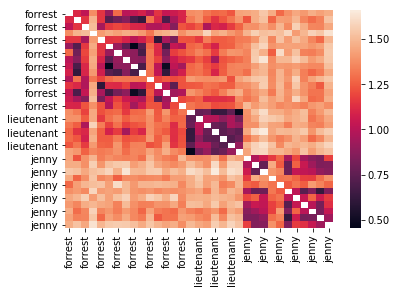

In [8]:
sns.heatmap(images_distance[(images_distance != 0)])

### Try manually on hard example

In [9]:
nets = _load_detect_nets()

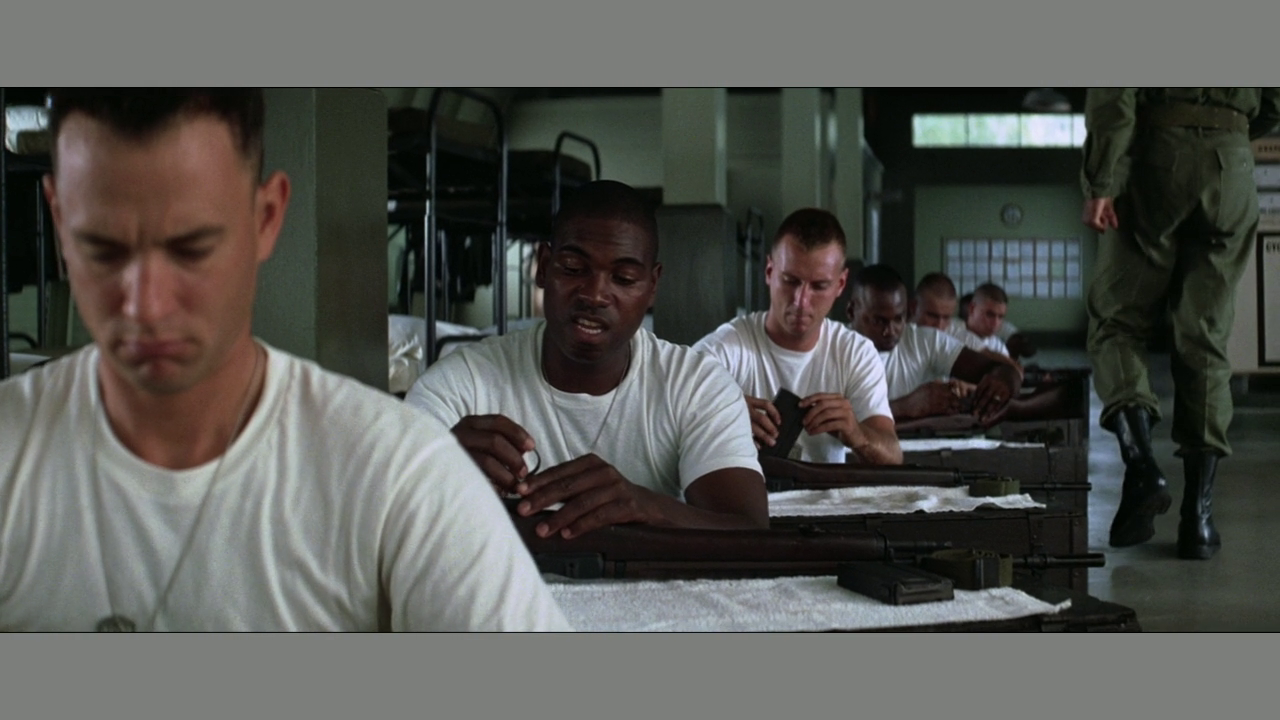

In [10]:
img_path = paths[3]
Image(img_path)

In [11]:
img = imageio.imread(img_path)
bounding_boxes  = _detect_faces(img, nets)

In [12]:
len(bounding_boxes)

5

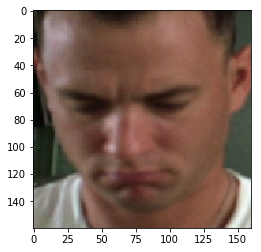

In [13]:
plt.imshow(standardize(crop_face(img, bounding_boxes[2])))

### Face detection display

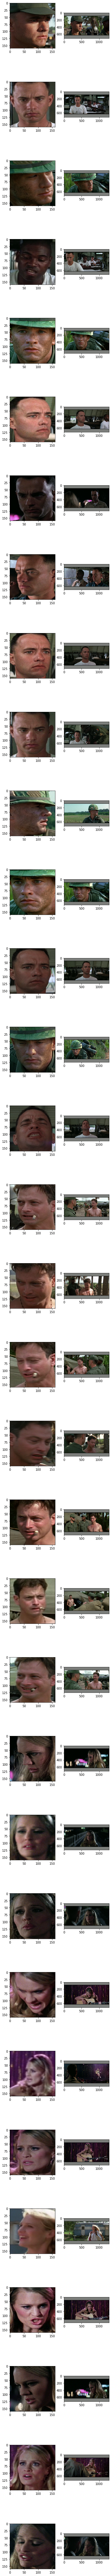

In [15]:
f, axarr = plt.subplots(len(images), 2, figsize=(6, 160))
for ix, i in enumerate(images):
    axarr[ix, 0].imshow(standardize(i))
    axarr[ix, 1].imshow(imageio.imread(paths[ix]))


### Cluster faces

In [17]:
def face_distance(face_encodings, face_to_compare):
    """
    Given a list of face encodings, compare them to a known face encoding and get a euclidean distance
    for each comparison face. The distance tells you how similar the faces are.
    :param faces: List of face encodings to compare
    :param face_to_compare: A face encoding to compare against
    :return: A numpy ndarray with the distance for each face in the same order as the 'faces' array
    """
    import numpy as np
    if len(face_encodings) == 0:
        return np.empty((0))

    #return 1/np.linalg.norm(face_encodings - face_to_compare, axis=1)
    return np.sum(face_encodings*face_to_compare,axis=1)

def chinese_whispers(image_paths, encodings, threshold=0.55, iterations=20):
    """ Chinese Whispers Algorithm
    Modified from Alex Loveless' implementation,
    http://alexloveless.co.uk/data/chinese-whispers-graph-clustering-in-python/
    Inputs:
        image_paths: paths_to_images
        encodings: image encodings
        threshold: facial match threshold,default 0.6
        iterations: since chinese whispers is an iterative algorithm, number of times to iterate
    Outputs:
        sorted_clusters: a list of clusters, a cluster being a list of imagepaths,
            sorted by largest cluster to smallest
    """

    #from face_recognition.api import _face_distance
    from random import shuffle
    import networkx as nx
    # Create graph
    nodes = []
    edges = []

    if len(encodings) <= 1:
        print ("No enough encodings to cluster!")
        return []

    for idx, face_encoding_to_check in enumerate(encodings):
        # Adding node of facial encoding
        node_id = idx+1

        # Initialize 'cluster' to unique value (cluster of itself)
        node = (node_id, {'cluster': image_paths[idx], 'path': image_paths[idx]})
        nodes.append(node)

        # Facial encodings to compare
        if (idx+1) >= len(encodings):
            # Node is last element, don't create edge
            break

        compare_encodings = encodings[idx+1:]
        distances = face_distance(compare_encodings, face_encoding_to_check)
        encoding_edges = []
        for i, distance in enumerate(distances):
            if distance > threshold:
                # Add edge if facial match
                edge_id = idx+i+2
                encoding_edges.append((node_id, edge_id, {'weight': distance}))

        edges = edges + encoding_edges

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # Iterate
    for _ in range(0, iterations):
        cluster_nodes = list(G.nodes())
        shuffle(cluster_nodes)
        for node in cluster_nodes:
            neighbors = G[node]
            clusters = {}

            for ne in neighbors:
                if isinstance(ne, int):
                    if G.node[ne]['cluster'] in clusters:
                        clusters[G.node[ne]['cluster']] += G[node][ne]['weight']
                    else:
                        clusters[G.node[ne]['cluster']] = G[node][ne]['weight']

            # find the class with the highest edge weight sum
            edge_weight_sum = 0
            max_cluster = 0
            #use the max sum of neighbor weights class as current node's class
            for cluster in clusters:
                if clusters[cluster] > edge_weight_sum:
                    edge_weight_sum = clusters[cluster]
                    max_cluster = cluster

            # set the class of target node to the winning local class
            G.node[node]['cluster'] = max_cluster

    clusters = {}

    # Prepare cluster output
    for (_, data) in G.node.items():
        cluster = data['cluster']
        path = data['path']

        if cluster:
            if cluster not in clusters:
                clusters[cluster] = []
            clusters[cluster].append(path)

    # Sort cluster output
    sorted_clusters = sorted(clusters.values(), key=len, reverse=True)

    return sorted_clusters

In [18]:
chinese_whispers(paths, embs)

[['/media/neuroscout-data/neuroscout/file_data/stimuli/fadd4b7515219897d3248c67fe82118ee79b18d4.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/9ea4ba2aa79a7eb83cdc3c2bb0e2d92fe63ae1db.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/f8f83976235caafae7a2846607de07c93fbc2e7b.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/f8a31d5952dc89acb1740715a663a511b8bdf118.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/323bb888180cd8cc624af8fc1b3680d4a2616578.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/4422b0d33ad012d9cb33fb5d7a8be39dd9aa2295.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/524be49e9ab7cefcd2695011e6eaf26ca803b92a.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/76fc2f36d0701bbd819634de6f7d73fc71f651d1.png',
  '/media/neuroscout-data/neuroscout/file_data/stimuli/95e7e97d946d4af7bf2b3955c6a110c55a07cb4e.png'],
 ['/media/neuroscout-data/neuroscout/file_data/stimuli/6c5786977c4763c66c9fdadd91